Let the RK45 solver decide how many points we should have and then, evaluate the solution

In [1]:
import scipy.integrate as integrate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd, lstsq, norm
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model

In [2]:
#some most useful functions for data generations are now in scripts/mechanisms.py 
import sys
sys.path.insert(1, 'scripts/')
import scripts.mechanisms as mechanisms
import scripts.ls_solvers as solvers

In [3]:
plt.style.use('default')
plt.rcParams["figure.figsize"] = (12,9)
plt.rcParams.update({'font.size': 19})

In [4]:
integration = 'RK45'
differentiation = 'spline'
rtol = 1e-6
npts = 87
tmax = 100
t_eval = (1-np.cos(np.linspace(0,np.pi,npts)))/2 * tmax #chebyshev

In [5]:
constants = [1, 1, 1, 0]

In [6]:
k1, k_1, k2, k_2 = constants
W0 = np.array([[0, 0, 0, k_1, 0, -k1, 0,    0, 0, 0,  0,    0, 0, 0  ],
               [0, 0, 0, k2,      0, 0,   -k_2, 0, 0, 0,  0,    0, 0, 0 ],
               [0, 0, 0, k2+k_1,  0, -k1, -k_2, 0, 0, 0, 0,    0, 0, 0  ],
               [0, 0, 0, -k2-k_1, 0,  k1,  k_2, 0, 0, 0, 0,    0, 0, 0  ]])
W0.shape

(4, 14)

In [7]:
#initial values
U0 = np.array([1.0, 0.0, 0.1, 0.0])
# U0 = np.vstack((U0, [1.0, 0.0, 0.15, 0.0]))
# U0 = np.vstack((U0, [1.0, 0.0, 0.05, 0.0]))

In [8]:
# if we have only one initial condition
U0 = U0.reshape((1,4))

In [9]:
X, T, Y = mechanisms.find_solutions(U0, constants, 'A1r', differentiation, tmax, rtol, integration, t_eval) # checked fine

RK45


Text(0.5, 1.0, 'Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 0$')

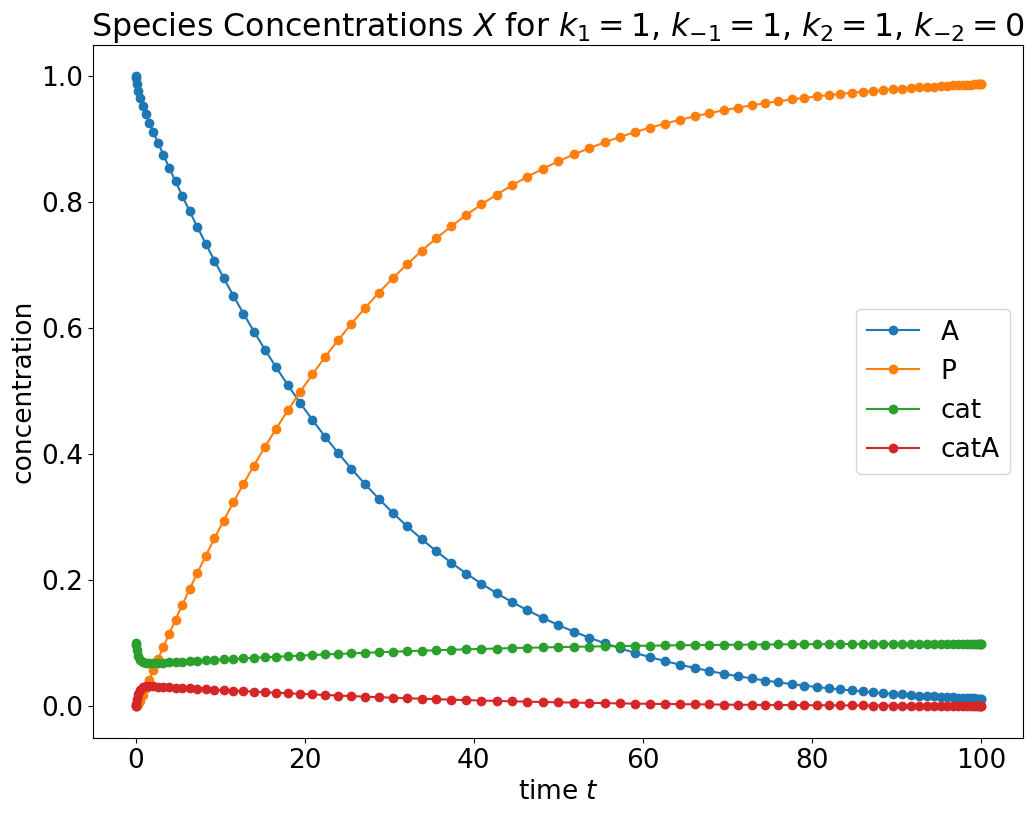

In [10]:
mechanisms.plot_concentrations(T, X, 'A1r')
plt.title('Species Concentrations $X$ for $k_1 = 1$, $k_{-1} = 1$, $k_2 = 1$, $k_{-2} = 0$')

In [11]:
Y_gt = mechanisms.ode(T, X.T, constants, 'A1r').T

In [12]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.00013092788002533326
relative residual 0.0003821149918384281


(0.00013092788002533326, 0.0003821149918384281)

Text(0.5, 1.0, 'Spline Approximation at Chebyshev Points')

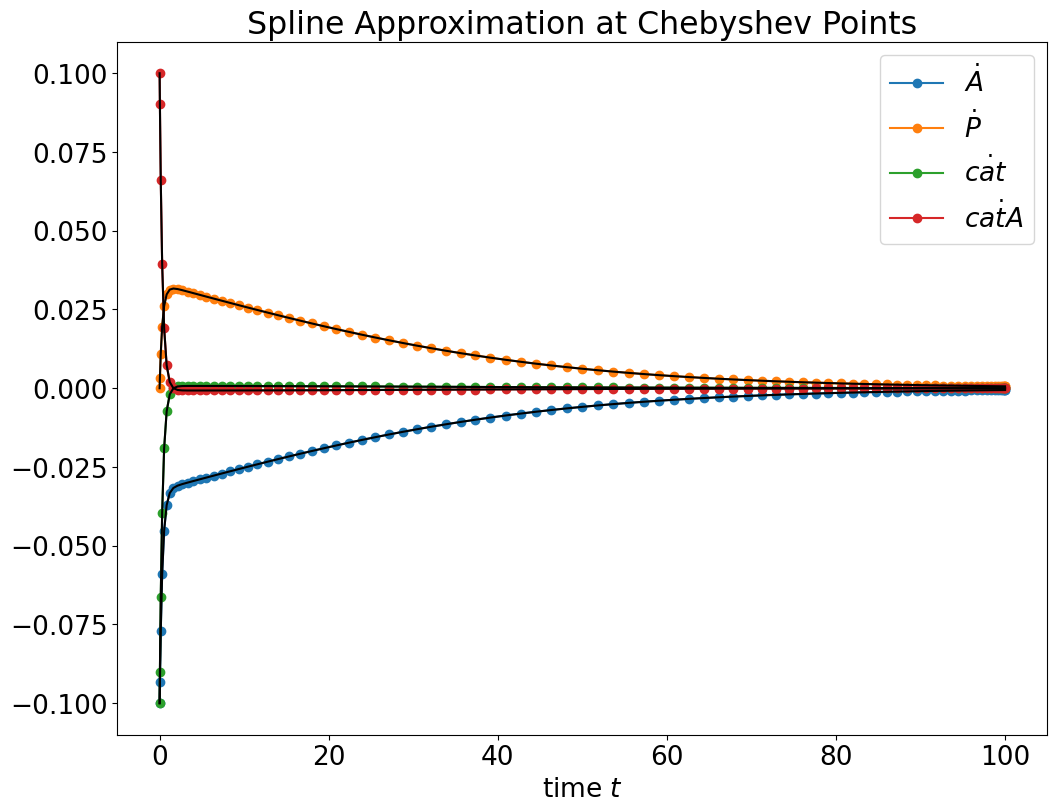

In [13]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, '-k')
plt.title('Spline Approximation at Chebyshev Points')

<function matplotlib.pyplot.show(*args, **kw)>

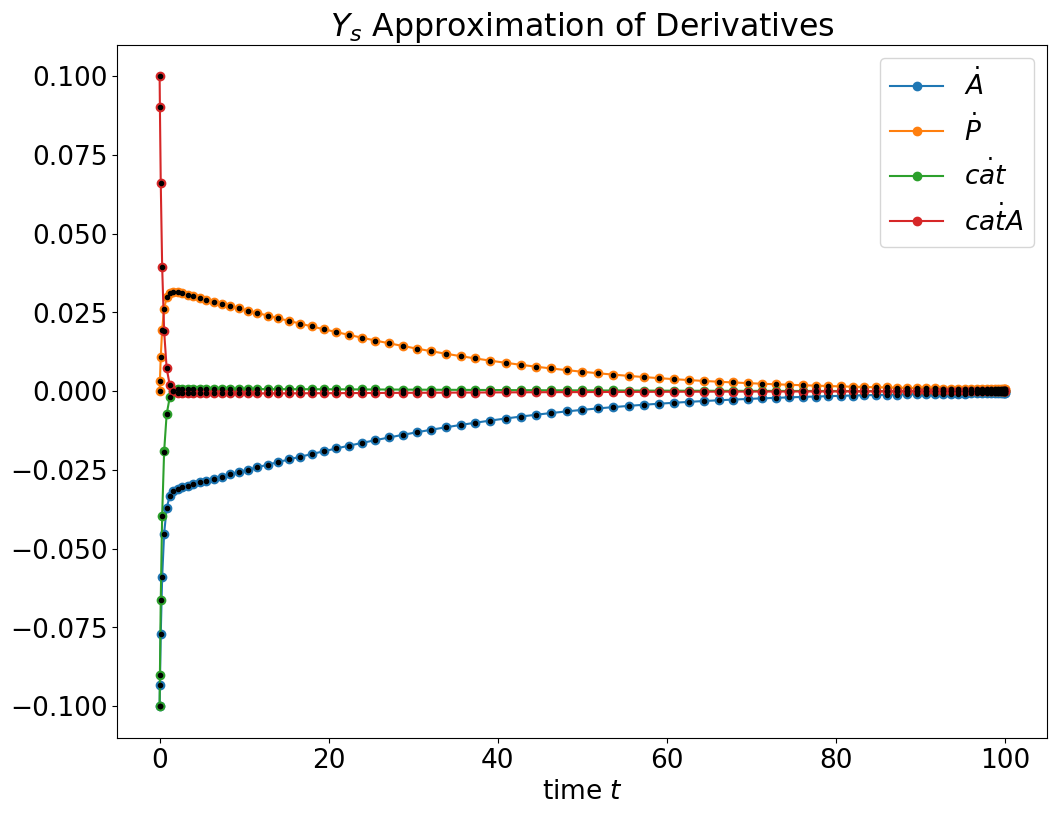

In [14]:
mechanisms.plot_derivatives(T, Y, 'A1r')
plt.plot(T, Y_gt, ".k")
plt.title('$Y_{s}$ Approximation of Derivatives')
plt.show

In [15]:
mechanisms.get_residual(Y, Y_gt)

absolute residual 0.00013092788002533326
relative residual 0.0003821149918384281


(0.00013092788002533326, 0.0003821149918384281)

## Basic LS solver 

Our first test is to solve the above least squares problem as is, that is, without any regularisation or sparsity promoting terms. Note that minimizing the Frobenius norm over matrices in this problem is the same as solving $d$ ordinary least squares problem for each column of $Y$ and $Y'$. So we can just solve them one after another to get the coefficients for each of the $d$ equations.

As can be seen, this leads to a dense solution (all coeffs are nonzero). We can also check the relative residual of the solution to get some idea about the noise level. Note the residual is relatively large (close to 1 percent) and I think this is due to the numerical differentiation.

Creating $[n\times m]$ features matrix $\widetilde{X}$ 

In [16]:
X_tilde, labels = mechanisms.get_features(X, 'A1r', square=True)

added squared terms
X_tilde features matrix shape:  (87, 14)
labels:  ['A', 'P', 'cat', 'catA', 'P*A', 'cat*A', 'cat*P', 'catA*A', 'catA*P', 'catA*cat', 'A*A', 'P*P', 'cat*cat', 'catA*catA']


In [17]:
rtol=1e-6

In [18]:
W_lsq = solvers.lsq(X_tilde, Y)


equation #0
relative residual 0.00021151284817321216
coefficients [ 0.15610179 -0.00771735 -0.48329381  0.55348028 -0.10642929 -0.41318366
 -0.03932895  0.42879383  0.03855722 -0.0307812  -0.16626275  0.06015472
 -0.01754818  0.08612923]

equation #1
relative residual 0.00015427740733373575
coefficients [ 0.06913876  0.07016116 -0.36104224  0.41663581 -0.04316867 -0.12647545
 -0.12824802  0.13338933  0.13526413 -0.10631877 -0.0210819  -0.02193431
  0.07021455  0.14798235]

equation #2
relative residual 0.00043589176993840274
coefficients [ 0.22524055  0.06244381 -0.84433605  0.97011609 -0.14959796 -0.53965911
 -0.16757697  0.56218316  0.17382135 -0.13709997 -0.18734465  0.03822042
  0.05266637  0.23411158]

equation #3
relative residual 0.00043589176993797025
coefficients [-0.22524055 -0.06244381  0.84433605 -0.97011609  0.14959796  0.53965911
  0.16757697 -0.56218316 -0.17382135  0.13709997  0.18734465 -0.03822042
 -0.05266637 -0.23411158]


In [19]:
s = mechanisms.print_equation(labels, W_lsq, rtol)
equations = mechanisms.string_equation(labels, W_lsq, rtol) 

+0.16[A]-0.01[P]-0.48[cat]+0.55[catA]-0.11[P*A]-0.41[cat*A]-0.04[cat*P]+0.43[catA*A]+0.04[catA*P]-0.03[catA*cat]-0.17[A*A]+0.06[P*P]-0.02[cat*cat]+0.09[catA*catA]
______
+0.07[A]+0.07[P]-0.36[cat]+0.42[catA]-0.04[P*A]-0.13[cat*A]-0.13[cat*P]+0.13[catA*A]+0.14[catA*P]-0.11[catA*cat]-0.02[A*A]-0.02[P*P]+0.07[cat*cat]+0.15[catA*catA]
______
+0.23[A]+0.06[P]-0.84[cat]+0.97[catA]-0.15[P*A]-0.54[cat*A]-0.17[cat*P]+0.56[catA*A]+0.17[catA*P]-0.14[catA*cat]-0.19[A*A]+0.04[P*P]+0.05[cat*cat]+0.23[catA*catA]
______
-0.23[A]-0.06[P]+0.84[cat]-0.97[catA]+0.15[P*A]+0.54[cat*A]+0.17[cat*P]-0.56[catA*A]-0.17[catA*P]+0.14[catA*cat]+0.19[A*A]-0.04[P*P]-0.05[cat*cat]-0.23[catA*catA]
______
sparsity: 56
+0.15610179171300262*A-0.007717354218679334*P-0.48329380811839834*cat+0.5534802798531556*catA-0.10642929495002497*P*A-0.41318365536033513*cat*A-0.03932895365423064*cat*P+0.42879383453164327*catA*A+0.03855721823235974*catA*P-0.030781199103836285*catA*cat-0.16626274786860892*A*A+0.060154722498937274*P*P-0.01

now knowing the equations we find the solutions for equispaced points

In [20]:
npts = T.shape[0]
npts

87

In [21]:
tmax = T[-1]

In [22]:
t_eq = np.linspace(0,tmax,npts) 
t_eq

array([  0.        ,   1.1627907 ,   2.3255814 ,   3.48837209,
         4.65116279,   5.81395349,   6.97674419,   8.13953488,
         9.30232558,  10.46511628,  11.62790698,  12.79069767,
        13.95348837,  15.11627907,  16.27906977,  17.44186047,
        18.60465116,  19.76744186,  20.93023256,  22.09302326,
        23.25581395,  24.41860465,  25.58139535,  26.74418605,
        27.90697674,  29.06976744,  30.23255814,  31.39534884,
        32.55813953,  33.72093023,  34.88372093,  36.04651163,
        37.20930233,  38.37209302,  39.53488372,  40.69767442,
        41.86046512,  43.02325581,  44.18604651,  45.34883721,
        46.51162791,  47.6744186 ,  48.8372093 ,  50.        ,
        51.1627907 ,  52.3255814 ,  53.48837209,  54.65116279,
        55.81395349,  56.97674419,  58.13953488,  59.30232558,
        60.46511628,  61.62790698,  62.79069767,  63.95348837,
        65.11627907,  66.27906977,  67.44186047,  68.60465116,
        69.76744186,  70.93023256,  72.09302326,  73.25

In [23]:
X_lsq, T_lsq, Y_lsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations,
                                                     differentiation, tmax, rtol,
                                                     integration, t_eq)
# X_lsq, T_lsq, Y_lsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations,
#                                                      differentiation, tmax, rtol,
#                                                      integration, T)

In [24]:
#mechanisms.plot_concentrations(T_lsq, X_lsq, 'A1r')

In [25]:
_, er_y = mechanisms.get_residual(Y_lsq, Y)
_, er_gt = mechanisms.get_residual(Y_lsq, Y_gt)
_, er_x = mechanisms.get_residual(X_lsq, X)
_, er_w = mechanisms.get_residual(W_lsq, W0)

table = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['basic least squares'])

absolute residual 0.19668574636752792
relative residual 0.7985309396336565
absolute residual 0.19663399820900485
relative residual 0.7983208455805139
absolute residual 1.4830086703717518
relative residual 0.18139862363838197
absolute residual 2.5940821714675626
relative residual 1.0241673954075807


In [26]:
table

,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56


## Sequential Thresholded Least Squares

In [27]:
alpha = 0.5
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, t_eq)

-1.11[catA]
______

______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 5
-1.1073098073424816*catA
______

______
+1.9999628891587253*catA-0.9999325216504819*cat*A
______
-1.9999628891587298*catA+0.9999325216504843*cat*A
______


In [28]:
X_stlsq.shape

(87, 4)

In [29]:
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ ' +  '$\alpha$' + '=' + str(alpha)])
table = table.append(row)
table

absolute residual 0.19853035867962548
relative residual 0.8212264164987961
absolute residual 0.19847925703905853
relative residual 0.8210150331242879
absolute residual 7.229595324411603
relative residual 2.1076625543246705
absolute residual 2.5378641878522363
relative residual 0.757467860927257


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5


In [30]:
alpha = 0.4
W_stlsq = solvers.stlsq(X_tilde, Y, alpha)   
s = mechanisms.print_equation(labels, W_stlsq, 1e-2)
equations = mechanisms.string_equation(labels, W_stlsq, 1e-5)
X_stlsq, T_stlsq, Y_stlsq = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, t_eq)
_, er_y = mechanisms.get_residual(Y_stlsq, Y)
_, er_gt = mechanisms.get_residual(Y_stlsq, Y_gt)
_, er_x = mechanisms.get_residual(X_stlsq, X)
_, er_w = mechanisms.get_residual(W_stlsq, W0)

row =  pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['STLSQ, $\alpha$ = ' + str(alpha)])
table = table.append(row)
table

+1.00[catA]-1.00[cat*A]
______
+1.00[catA]
______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 7
+0.999969030344521*catA-0.9999520104102652*cat*A
______
+1.0000349290362114*catA
______
+1.9999628891587253*catA-0.9999325216504819*cat*A
______
-1.9999628891587298*catA+0.9999325216504843*cat*A
______
absolute residual 0.19670168091026063
relative residual 0.7985953435161041
absolute residual 0.19664993381723536
relative residual 0.7983852538649163
absolute residual 1.4829986778582718
relative residual 0.18139718285970347
absolute residual 0.00012784069086568876
relative residual 3.54575212099458e-05


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5
"STLSQ, $lpha$ = 0.4",0.798595,0.798385,0.181397,0.000035,7


In [31]:
# mechanisms.print_equation(labels, W_stlsq, 1e-5)

In [32]:
alphas = np.linspace(0.0, 10, 200)
W_stlsq_arr = []
for alpha in alphas: 
    w = solvers.stlsq(X_tilde, Y, alpha)  
    W_stlsq_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ using STLSQ')

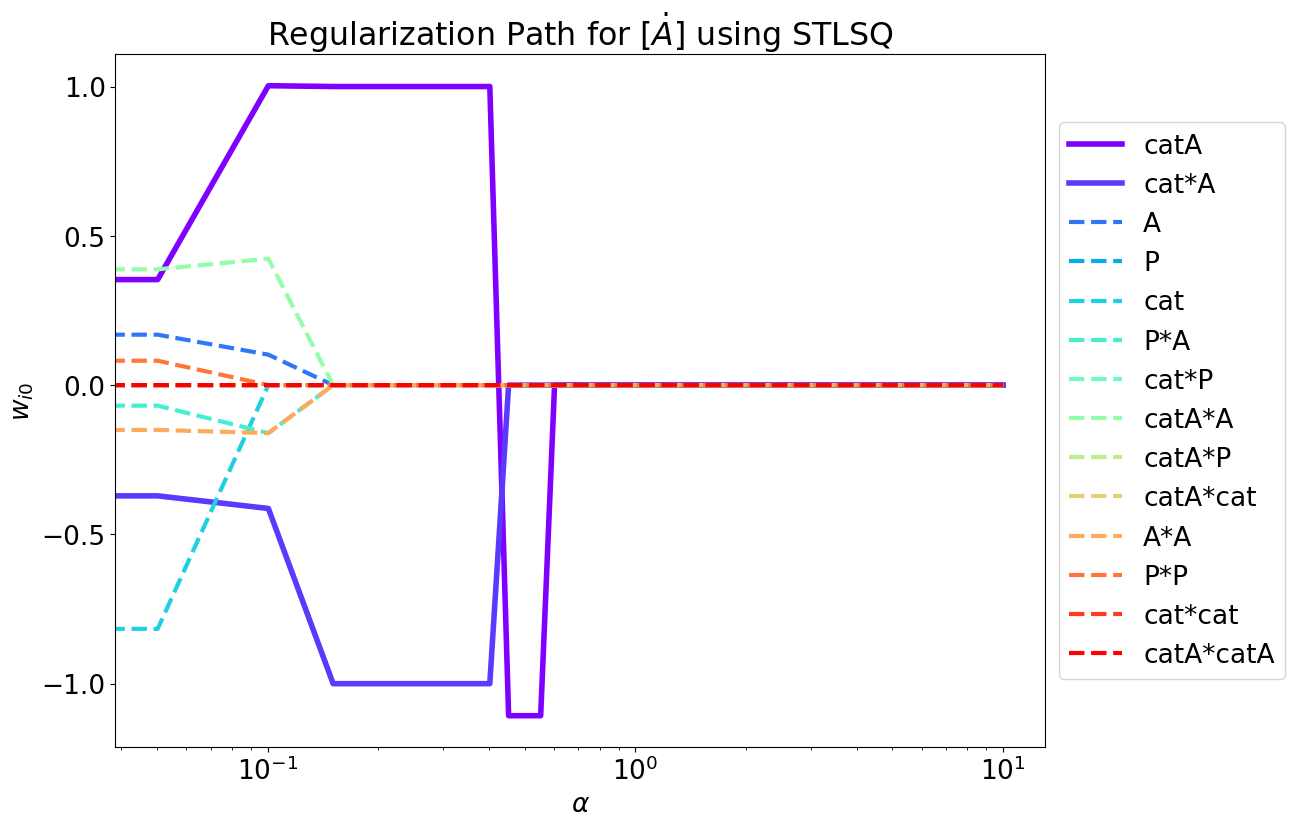

In [33]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 0, labels)
plt.title("Regularization Path for $[\dot{A}]$ using STLSQ")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ using STLSQ')

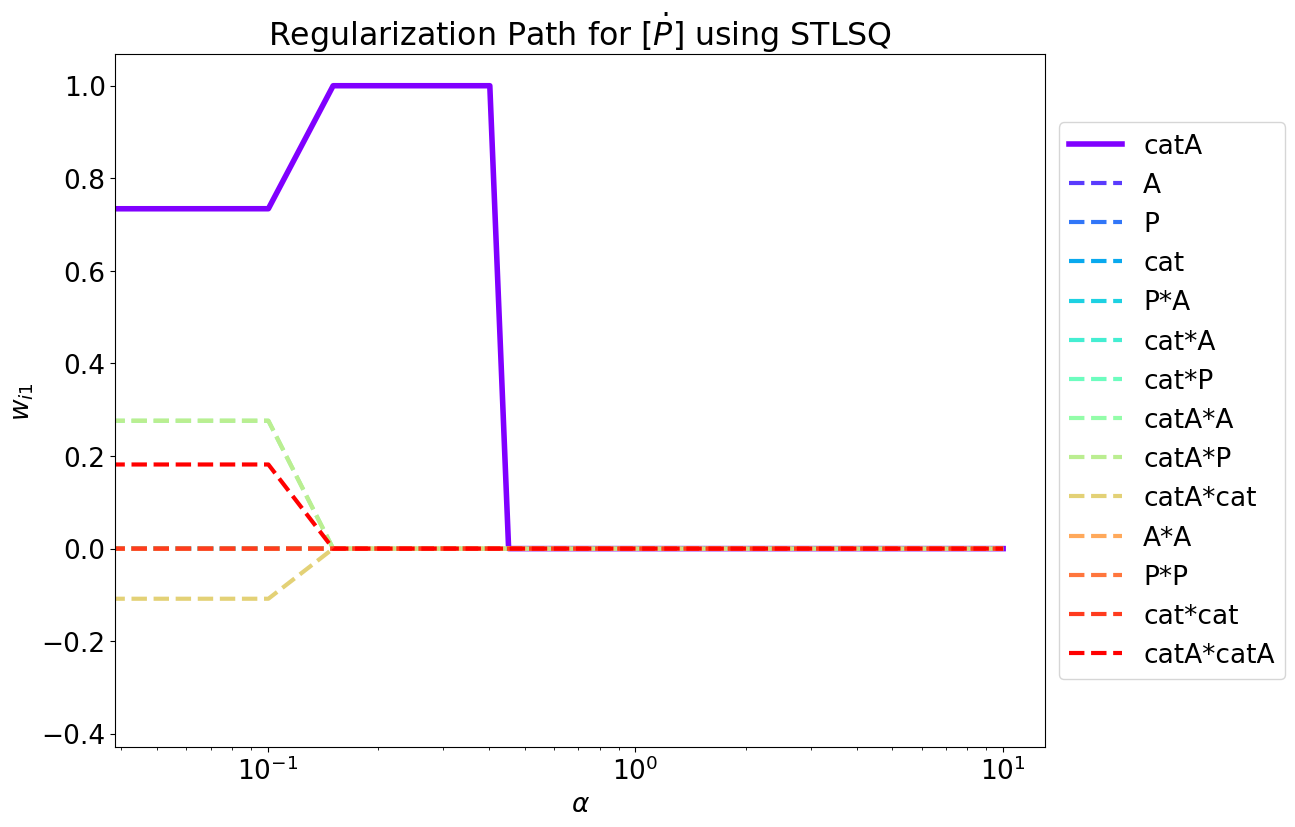

In [34]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 1, labels)
plt.title("Regularization Path for $[\dot{P}]$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using STLSQ')

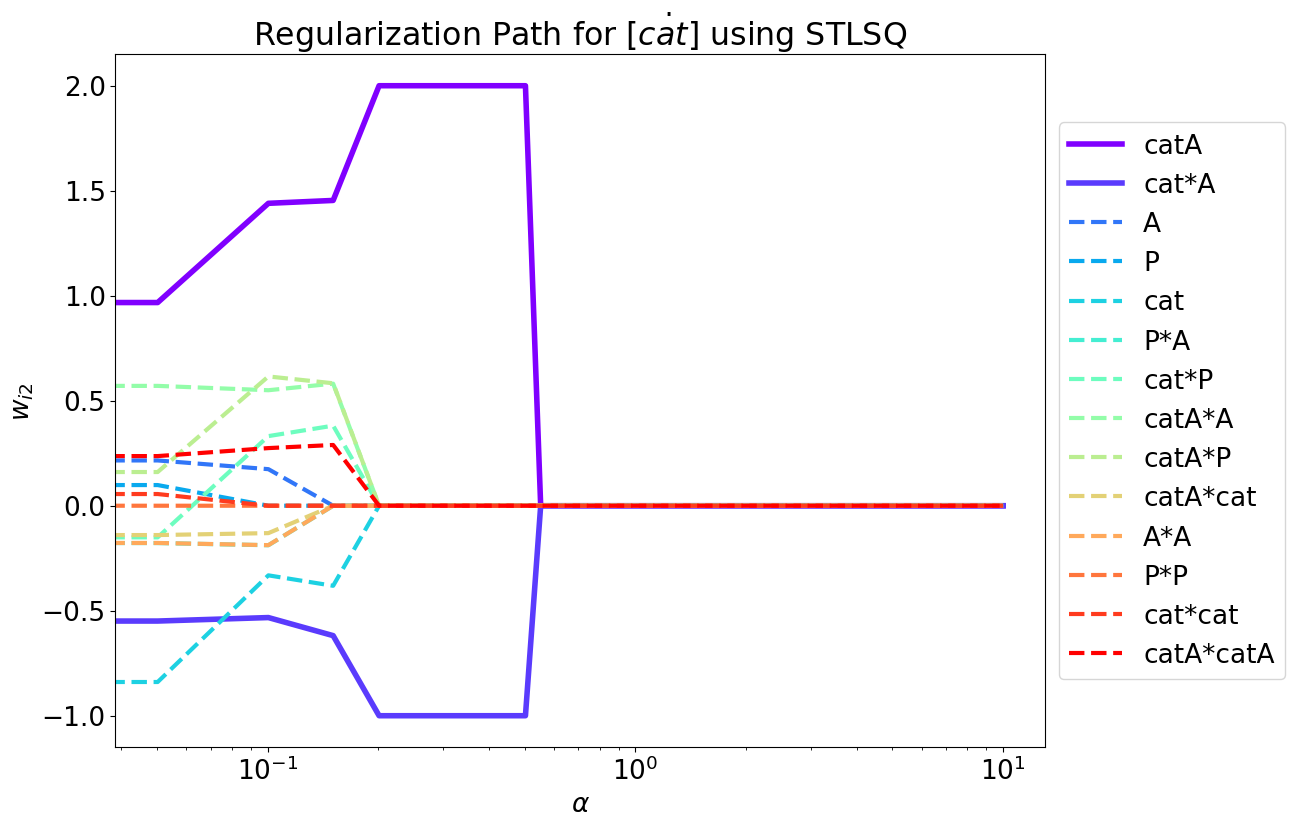

In [35]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 2, labels)
plt.title("Regularization Path for $[\dot{cat}]$ using STLSQ")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using STLSQ')

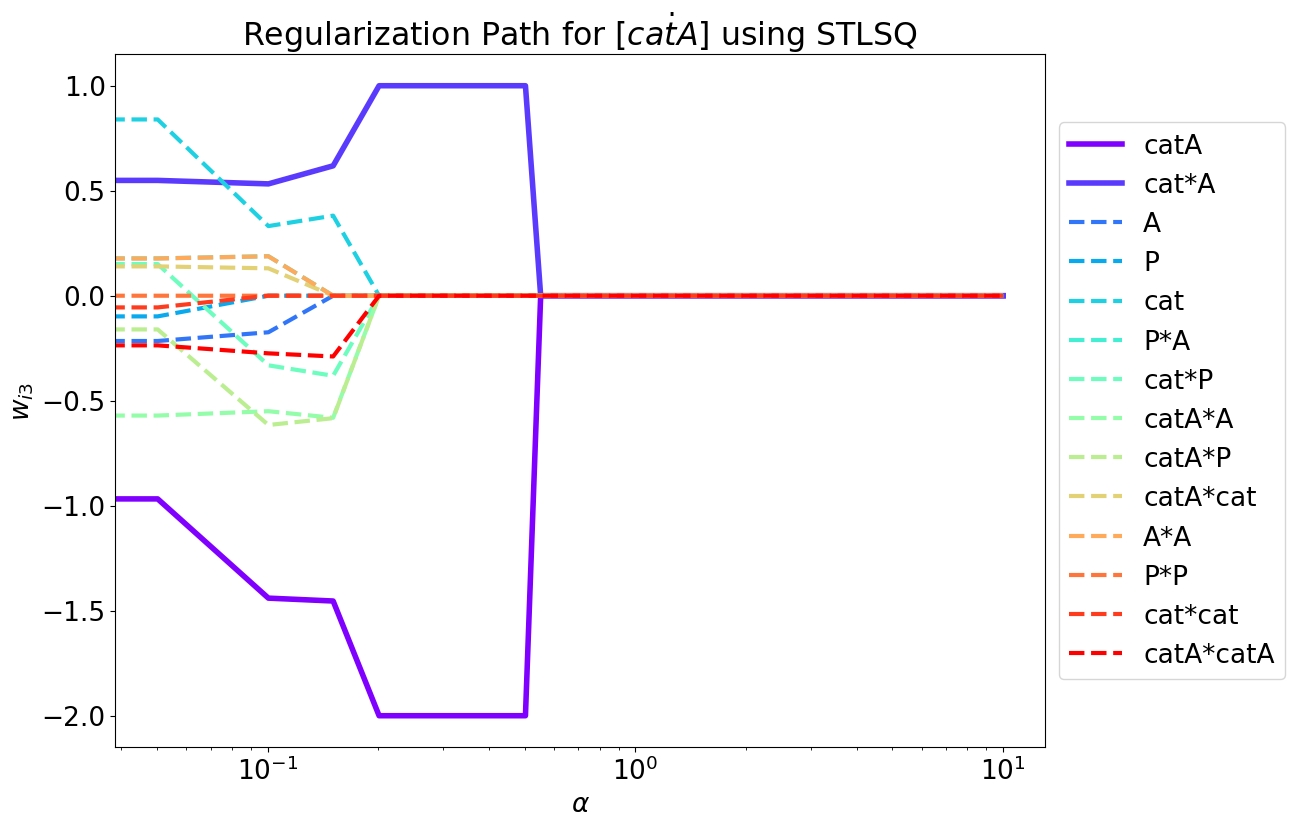

In [36]:
solvers.plot_regularization_path(alphas, np.array(W_stlsq_arr), W0, 3, labels)
plt.title("Regularization Path for $[\dot{catA}]$ using STLSQ")

# Lasso CVXPY


In [37]:
lambdas = np.logspace(-4, 0, 10)
W_lasso_arr = []
for lambd in lambdas: 
    w = solvers.lasso_cvxp(X_tilde, Y, lambd)  
    W_lasso_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{A}]$ using Lasso')

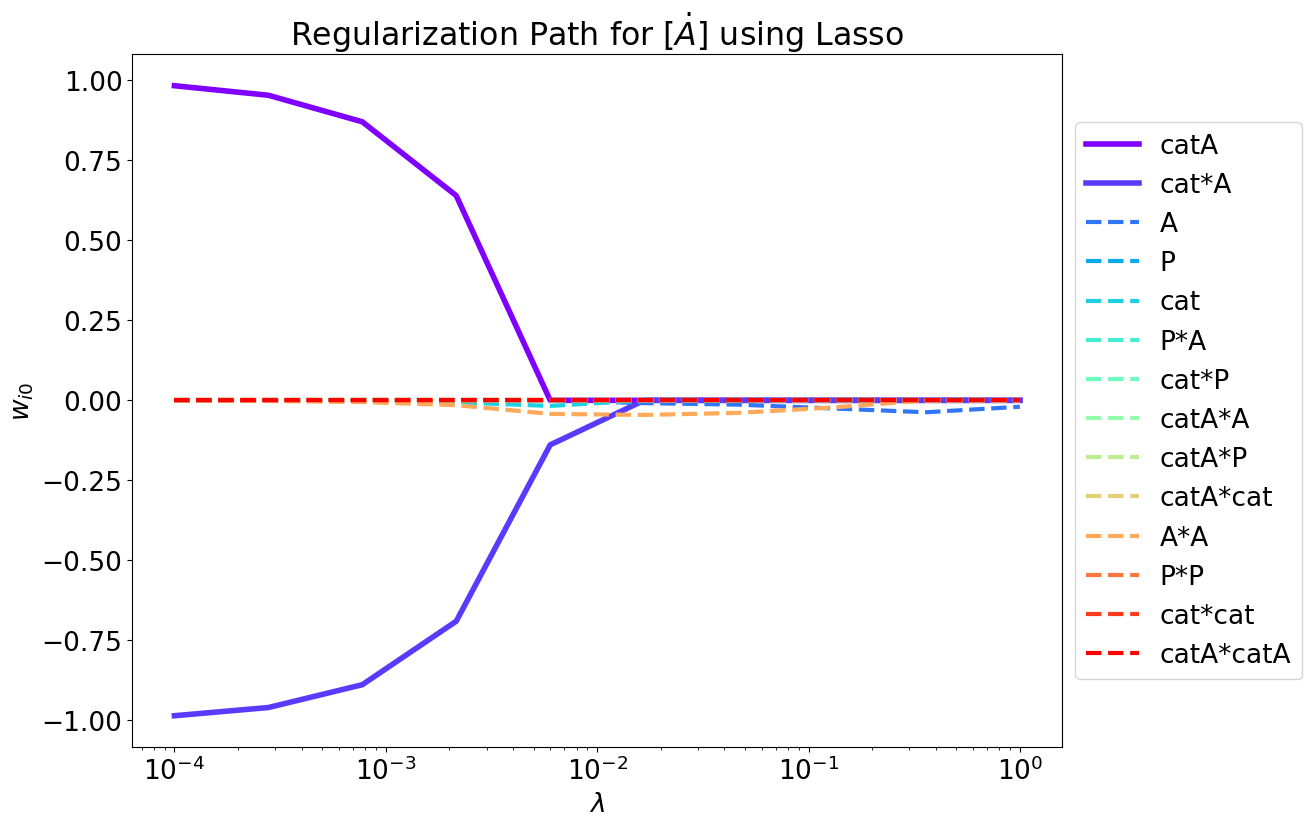

In [38]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 0, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{A}]$ using Lasso")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{P}]$ using Lasso')

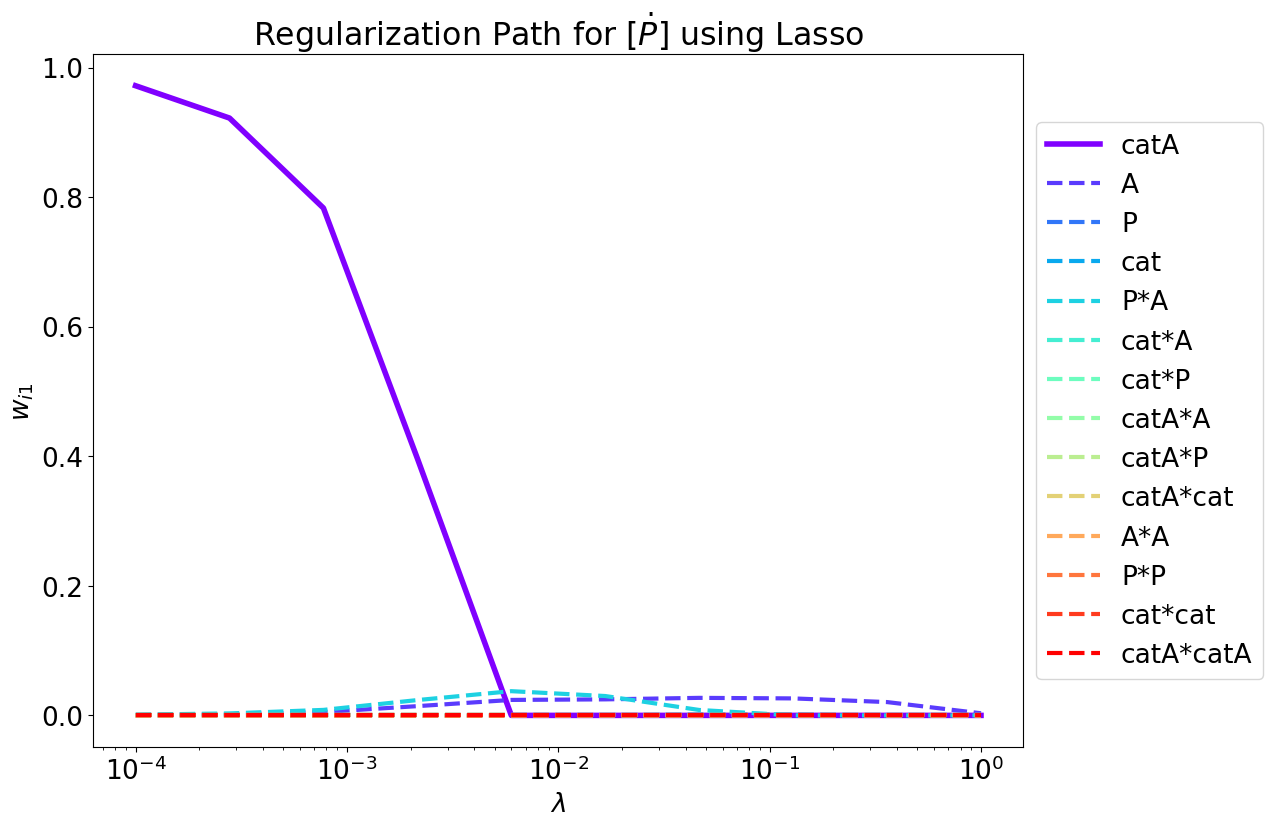

In [39]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 1, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{P}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{cat}]$ using Lasso')

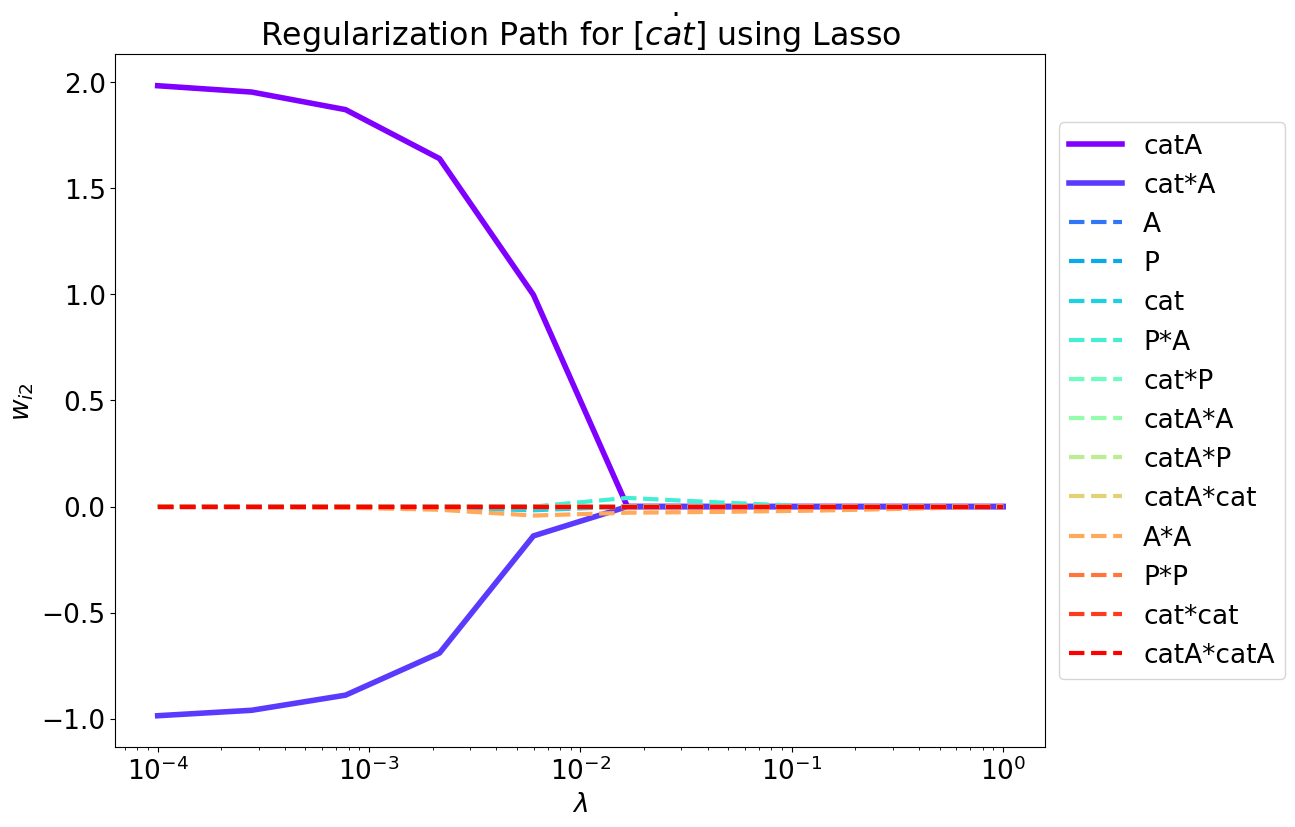

In [40]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 2, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{cat}]$ using Lasso")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $[\\dot{catA}]$ using Lasso')

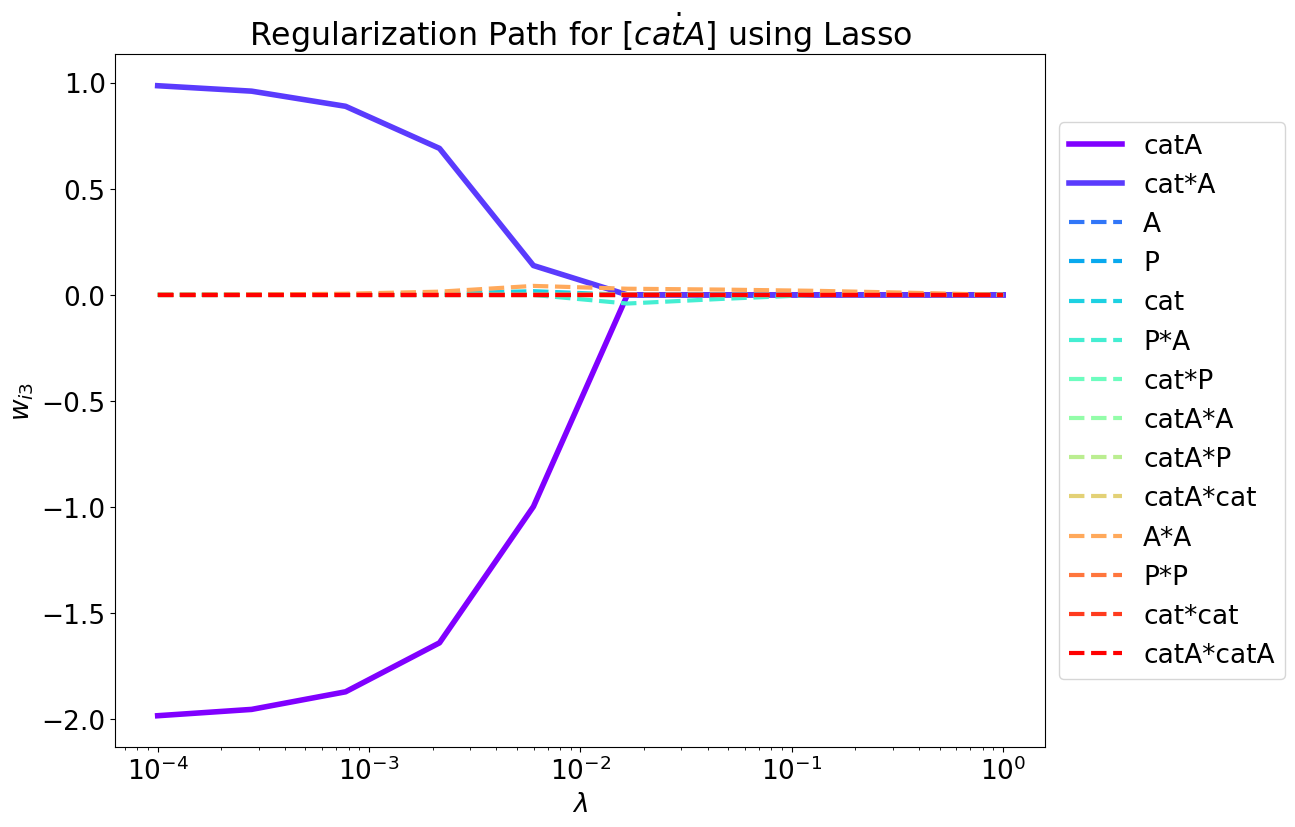

In [41]:
solvers.plot_regularization_path(lambdas, np.array(W_lasso_arr), W0, 3, labels)
plt.xlabel('$\lambda$')
plt.title("Regularization Path for $[\dot{catA}]$ using Lasso")

In [42]:
lambd = 1e-4
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+0.98[catA]-0.99[cat*A]
______
+0.97[catA]
______
+1.98[catA]-0.99[cat*A]
______
-1.98[catA]+0.99[cat*A]
______
sparsity: 7
-0.0002801909984416865*cat+0.9832373423310433*catA-0.9856856948777979*cat*A+1.7736933136066522e-05*catA*A-0.0006977363837225426*A*A
______
+0.0006649592771231257*A+0.9720152372324016*catA+0.0010910221894942383*P*A-1.7841835103776398e-05*P*P
______
-0.00027408119767478325*cat+1.9832304913971872*catA-0.9857246935493845*cat*A+1.6034431402616866e-05*catA*A-0.0006928531035062102*A*A
______
+0.00027408099354036565*cat-1.983230489240481*catA+0.9857246927335928*cat*A-1.6032998689279446e-05*catA*A+0.0006928530908371347*A*A
______
absolute residual 0.001126804627108767
relative residual 0.003287001382612706
absolute residual 0.0011542365917242016
relative residual 0.003367023156973074
absolute residual 0.005213731410698475
relative residual 0.0006228121947603603
absolute residual 0.04735339455082852
relative residual 0.013291418877341839


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5
"STLSQ, $lpha$ = 0.4",0.798595,0.798385,0.181397,0.000035,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003287,0.003367,0.000623,0.013291,7


In [43]:
lambd = 1e-3
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+0.83[catA]-0.86[cat*A]
______
+0.72[catA]+0.01[P*A]
______
+1.83[catA]-0.86[cat*A]
______
-1.83[catA]+0.86[cat*A]
______
sparsity: 8
-0.0029182263223181235*cat+0.8327685994790122*catA-0.856306704473642*cat*A-0.007057375046655768*A*A
______
+0.0066319047835431*A+0.7199871429870339*catA+0.010968053806572207*P*A-0.00018268339014468723*P*P
______
-0.0029129961821172143*cat+1.8327612157090984*catA-0.8563496345180458*cat*A-0.007052065702164672*A*A
______
+0.002912996212330864*cat-1.832761215562626*catA+0.8563496343482125*cat*A+0.007052065709493749*A*A
______
absolute residual 0.012600758142652262
relative residual 0.036593774433035894
absolute residual 0.012632897427630328
relative residual 0.036687109907902714
absolute residual 0.06357555851359109
relative residual 0.0076266676492588985
absolute residual 0.47388696154538523
relative residual 0.14889020763050798


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5
"STLSQ, $lpha$ = 0.4",0.798595,0.798385,0.181397,0.000035,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003287,0.003367,0.000623,0.013291,7
"Lasso_cvxp, $\lambda$ = 0.001",0.036594,0.036687,0.007627,0.148890,8


In [44]:
lambd = 1e-5
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+1.00[catA]-1.00[cat*A]
______
+1.00[catA]
______
+2.00[catA]-1.00[cat*A]
______
-2.00[catA]+1.00[cat*A]
______
sparsity: 7
-1.633096007954575e-05*cat+0.9982415137183069*catA-0.9986126838462551*cat*A+3.708609367562718e-05*catA*A-6.202077540759961e-05*A*A
______
+7.050961405448444e-05*A+0.9972214526877694*catA+0.00010115389896736774*P*A
______
-1.3611626175616737e-05*cat+1.9982276547705486*catA-0.9986149053755478*cat*A+9.849892042721522e-05*catA*A-6.09537129731073e-05*A*A
______
+1.368831454617502e-05*cat-1.9982265037307334*catA+0.9986142605808981*cat*A-0.00010014723730729964*catA*A+6.100820534954198e-05*A*A
______
absolute residual 0.00014459425833324193
relative residual 0.0004219563694573211
absolute residual 9.94987543329816e-05
relative residual 0.00029035823156346415
absolute residual 0.0005237172911792455
relative residual 6.253808413061274e-05
absolute residual 0.004786518553719573
relative residual 0.0013291552912036602


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5
"STLSQ, $lpha$ = 0.4",0.798595,0.798385,0.181397,0.000035,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003287,0.003367,0.000623,0.013291,7
"Lasso_cvxp, $\lambda$ = 0.001",0.036594,0.036687,0.007627,0.148890,8
"Lasso_cvxp, $\lambda$ = 1e-05",0.000422,0.000290,0.000063,0.001329,7


In [45]:
lambd = 3e-3
W_lasso = solvers.lasso_cvxp(X_tilde, Y, lambd)   
s = mechanisms.print_equation(labels, W_lasso, 1e-2)
equations = mechanisms.string_equation(labels, W_lasso, 1e-5)
X_lasso, T_lasso, Y_lasso = mechanisms.data_from_equations(U0, constants, 'A1r', equations, differentiation, tmax, rtol, integration, T)
_, er_y = mechanisms.get_residual(Y_lasso, Y)
_, er_gt = mechanisms.get_residual(Y_lasso, Y_gt)
_, er_x = mechanisms.get_residual(X_lasso, X)
_, er_w = mechanisms.get_residual(W_lasso, W0)

row = pd.DataFrame({'$\epsilon_r`(\hat{Y})$': [er_y],
                   '$\epsilon_r(\hat{Y})$': [er_gt], '$\epsilon_r(\hat{X})$': [er_x], '$\epsilon_r(\hat{W})$': [er_w],'s': [s]}, index = ['Lasso_cvxp, $\lambda$ = ' + str(lambd)])

table = table.append(row)
table

+0.50[catA]-0.57[cat*A]-0.02[A*A]
______
+0.02[A]+0.16[catA]+0.03[P*A]
______
+1.50[catA]-0.57[cat*A]-0.02[A*A]
______
-1.50[catA]+0.57[cat*A]+0.02[A*A]
______
sparsity: 12
-0.008771348962813038*cat+0.4983669078308173*catA-0.5687957118652033*cat*A-0.02119112136666706*A*A
______
+0.019892519946584947*A+0.1598906394925581*catA+0.03292229217849356*P*A-0.0005496090812246291*P*P
______
-0.00876594863661563*cat+1.4983563126666797*catA-0.5688307517907634*cat*A-0.021186438277588853*A*A
______
+0.008765948634091475*cat-1.4983563127517245*catA+0.5688307518665578*cat*A+0.021186438273860127*A*A
______
absolute residual 0.04613588071074159
relative residual 0.13173099437806637
absolute residual 0.04616387014423264
relative residual 0.13181091213077975
absolute residual 0.315343723389596
relative residual 0.03862894797427196
absolute residual 1.42180187086192
relative residual 0.593562364280998


,$\epsilon_r`(\hat{Y})$,$\epsilon_r(\hat{Y})$,$\epsilon_r(\hat{X})$,$\epsilon_r(\hat{W})$,s
basic least squares,0.798531,0.798321,0.181399,1.024167,56
STLSQ $lpha$=0.5,0.821226,0.821015,2.107663,0.757468,5
"STLSQ, $lpha$ = 0.4",0.798595,0.798385,0.181397,0.000035,7
"Lasso_cvxp, $\lambda$ = 0.0001",0.003287,0.003367,0.000623,0.013291,7
"Lasso_cvxp, $\lambda$ = 0.001",0.036594,0.036687,0.007627,0.148890,8
"Lasso_cvxp, $\lambda$ = 1e-05",0.000422,0.000290,0.000063,0.001329,7
"Lasso_cvxp, $\lambda$ = 0.003",0.131731,0.131811,0.038629,0.593562,12


# pySINDy

In [46]:
import pysindy as ps

In [47]:
def make_library(mechType):
    if mechType == 'A1r':
        feature_names = ['A', 'P', 'cat', 'catA']
    elif mechType == 'A1ra':
        feature_names = ['A', 'P', 'cat', 'catact', 'catactA']
    elif mechType == 'A2r':
        feature_names = ['A', 'P', 'cat', 'catA', 'B']
    library_functions = [
        lambda x : x,
        lambda x : x * x, 
        lambda x,y : x*y
    ]
    library_function_names = [
        lambda x : x ,
        lambda x :  x + '*' + x,
        lambda x,y : x + '*' + y 
    ]
    custom_library = ps.CustomLibrary(
         library_functions=library_functions, function_names=library_function_names,  
    )
    
    return [custom_library, feature_names]

In [48]:
opt = ps.STLSQ(threshold = 0.008, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()

(A)' = 0.788 catA + -0.010 A*A + -0.902 A*cat + 0.301 A*catA
(P)' = 0.447 A + -2.850 P + -2.170 cat + 2.144 catA + -0.414 A*A + 3.067 P*P + 2.651 A*P + 1.835 A*cat + -1.790 A*catA
(cat)' = 0.025 A + -0.944 cat + 3.025 catA + -0.101 A*A + 9.444 cat*cat + -0.107 A*P + -0.232 A*cat + 0.234 A*catA
(catA)' = -0.025 A + 0.944 cat + -3.025 catA + 0.101 A*A + -9.444 cat*cat + 0.107 A*P + 0.232 A*cat + -0.234 A*catA


In [49]:
W_sindy = model_custom.coefficients()

In [50]:
mechanisms.print_equation(labels, W_sindy, 1e-5)

+0.00[cat]+0.79[catA]-0.01[P*A]-0.90[catA*cat]+0.30[A*A]
______
+0.45[A]-2.85[P]-2.17[cat]+2.14[catA]-0.41[P*A]+3.07[cat*A]+2.65[catA*P]+1.83[catA*cat]-1.79[A*A]
______
+0.03[A]-0.94[cat]+3.03[catA]-0.10[P*A]+9.44[cat*P]-0.11[catA*P]-0.23[catA*cat]+0.23[A*A]
______
-0.03[A]+0.94[cat]-3.03[catA]+0.10[P*A]-9.44[cat*P]+0.11[catA*P]+0.23[catA*cat]-0.23[A*A]
______
sparsity: 30


30

In [51]:
W_sindy_arr = []
lambdas = np.linspace(0, 0.05, 100)
W_ridge_arr = []
for lambd in lambdas: 
    opt = ps.STLSQ(threshold = lambd, alpha=0.05) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031313131313131314) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.031818181818181815) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03232323232323232) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.03282828282828283) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pys

/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.04393939393939394) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.044444444444444446) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/py

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{A}$ equation using SINDy')

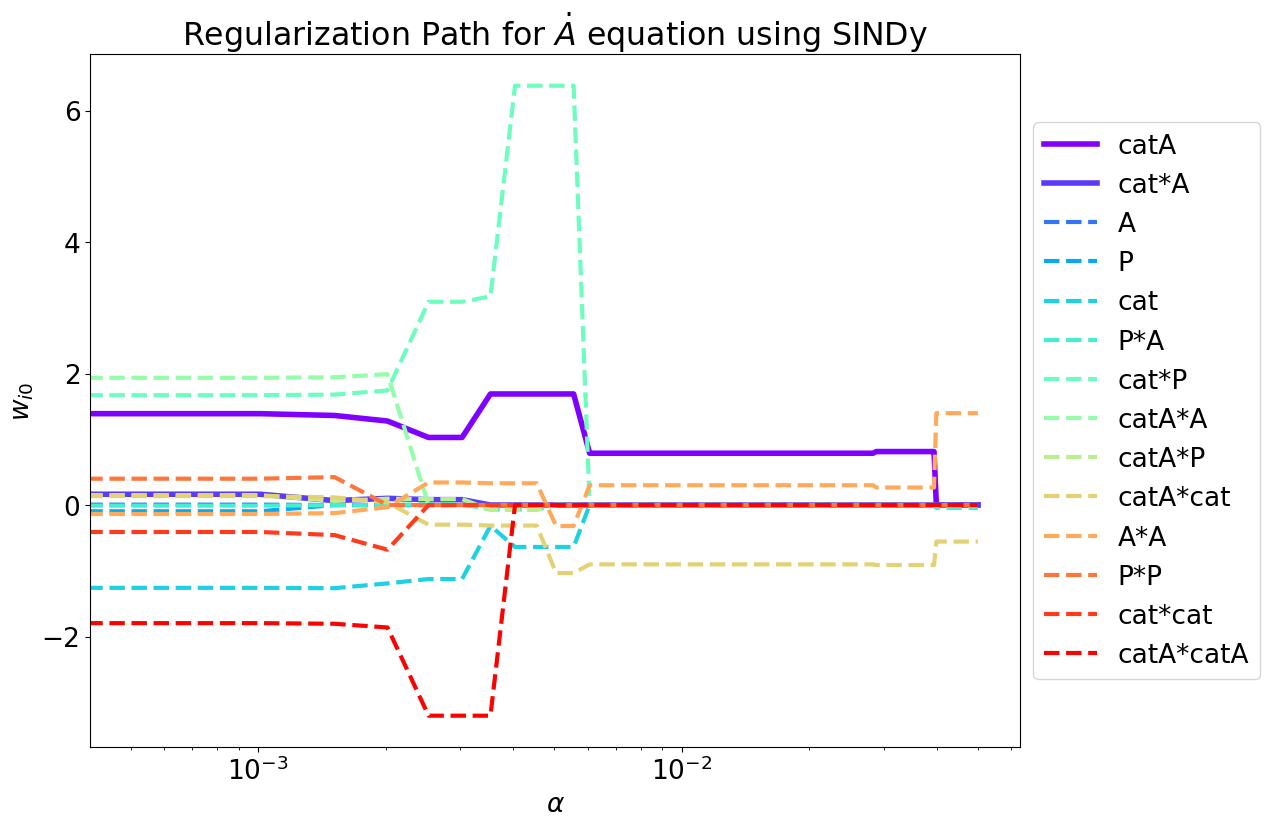

In [52]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $\dot{A}$ equation using SINDy")

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{P}$ equation using SINDy')

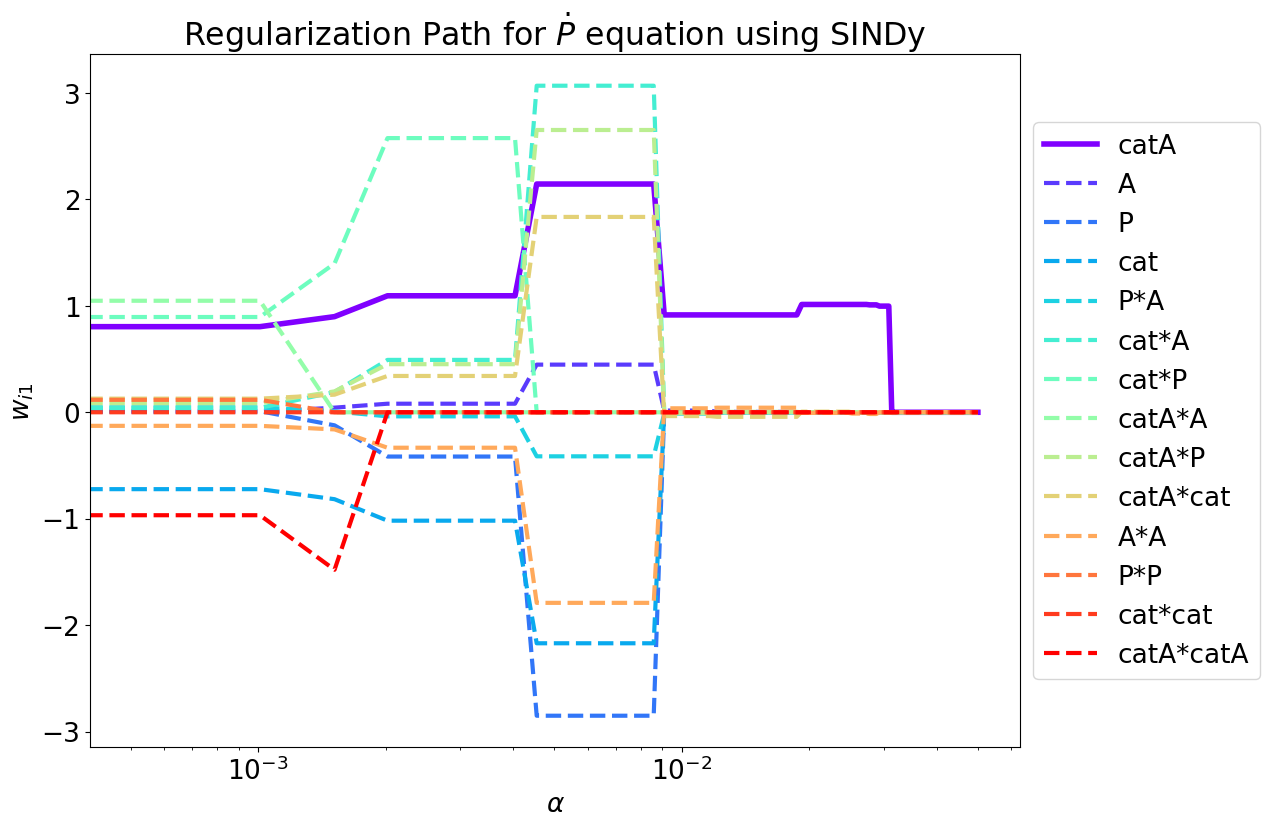

In [53]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $\dot{P}$ equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{cat}$ equation using SINDy')

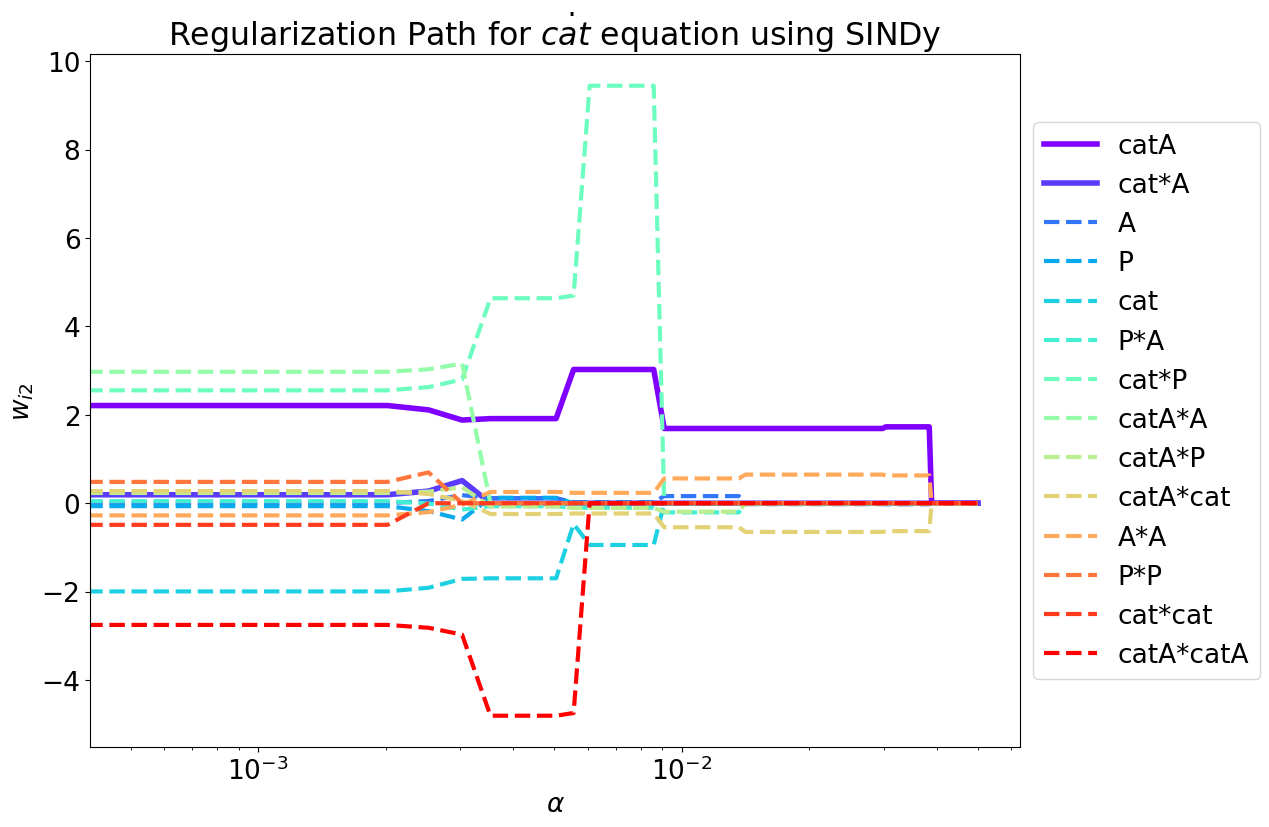

In [54]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $\dot{cat}$ equation using SINDy")

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 1.0, 'Regularization Path for $\\dot{catA}$ equation using SINDy')

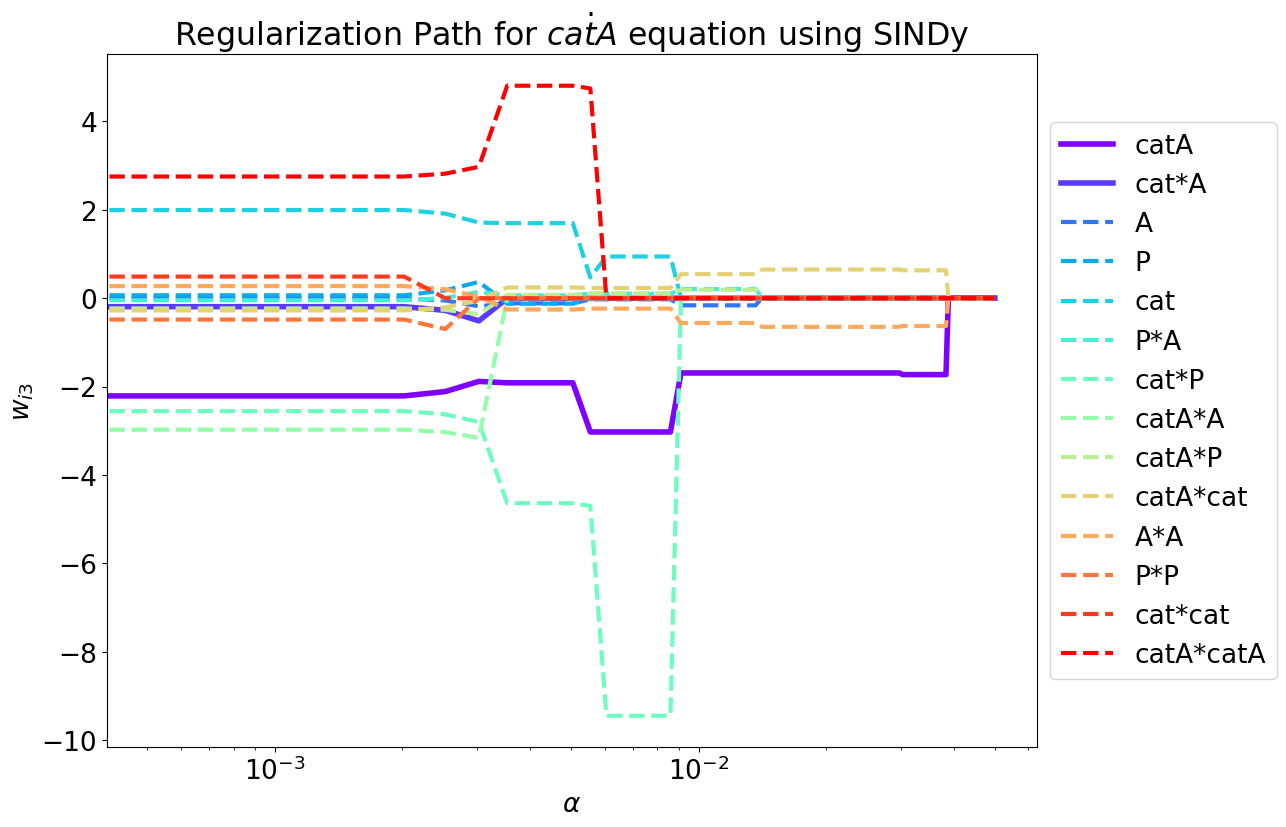

In [55]:
solvers.plot_regularization_path(lambdas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $\dot{catA}$ equation using SINDy")

In [56]:
W_sindy_arr = []
alphas = np.linspace(0, 0.2, 100)
W_ridge_arr = []
for alph in alphas: 
    opt = ps.STLSQ(threshold = 0.015, alpha=alph) 
    custom_library, feature_names = make_library('A1r')
    model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
    model_custom.fit(X, t =T)
    w = model_custom.coefficients()
    W_sindy_arr.append(w)

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

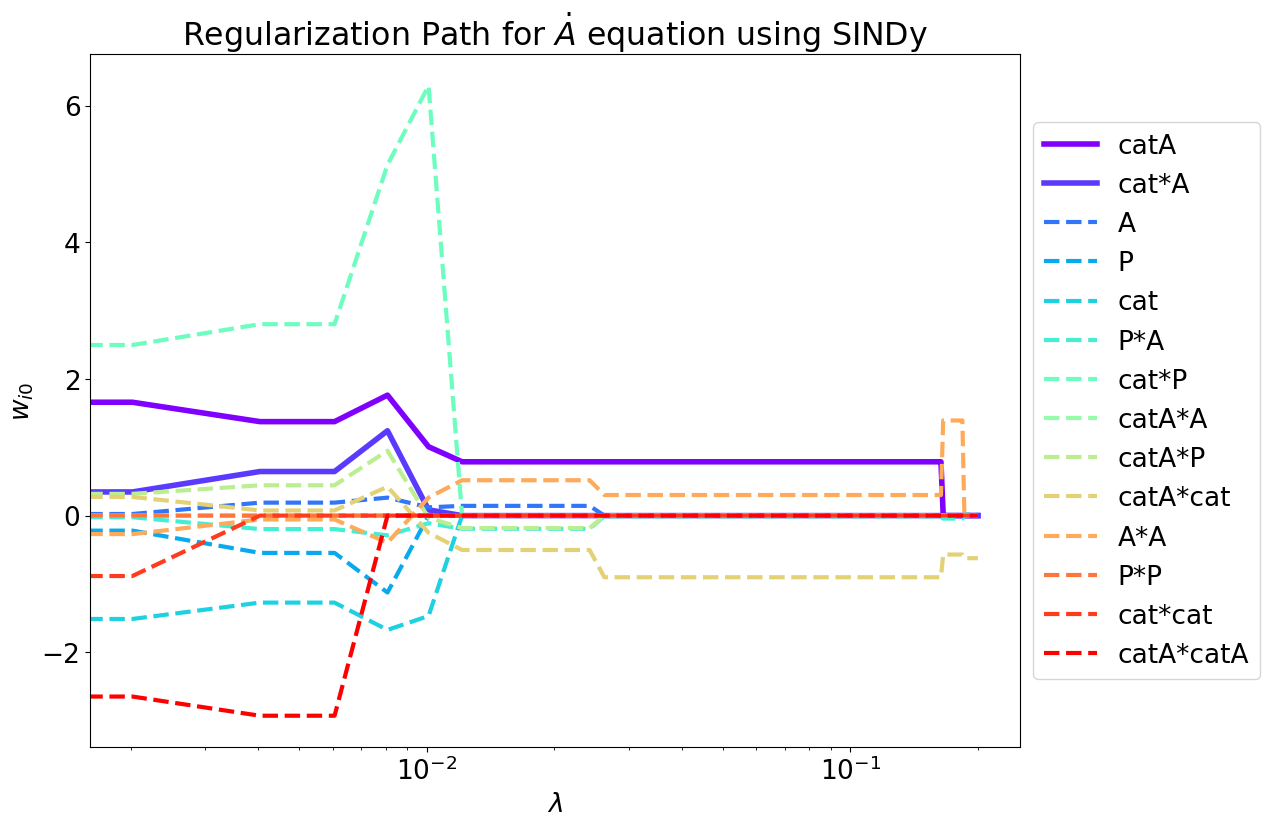

In [57]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 0, labels)
plt.title("Regularization Path for $\dot{A}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3]),)
(array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

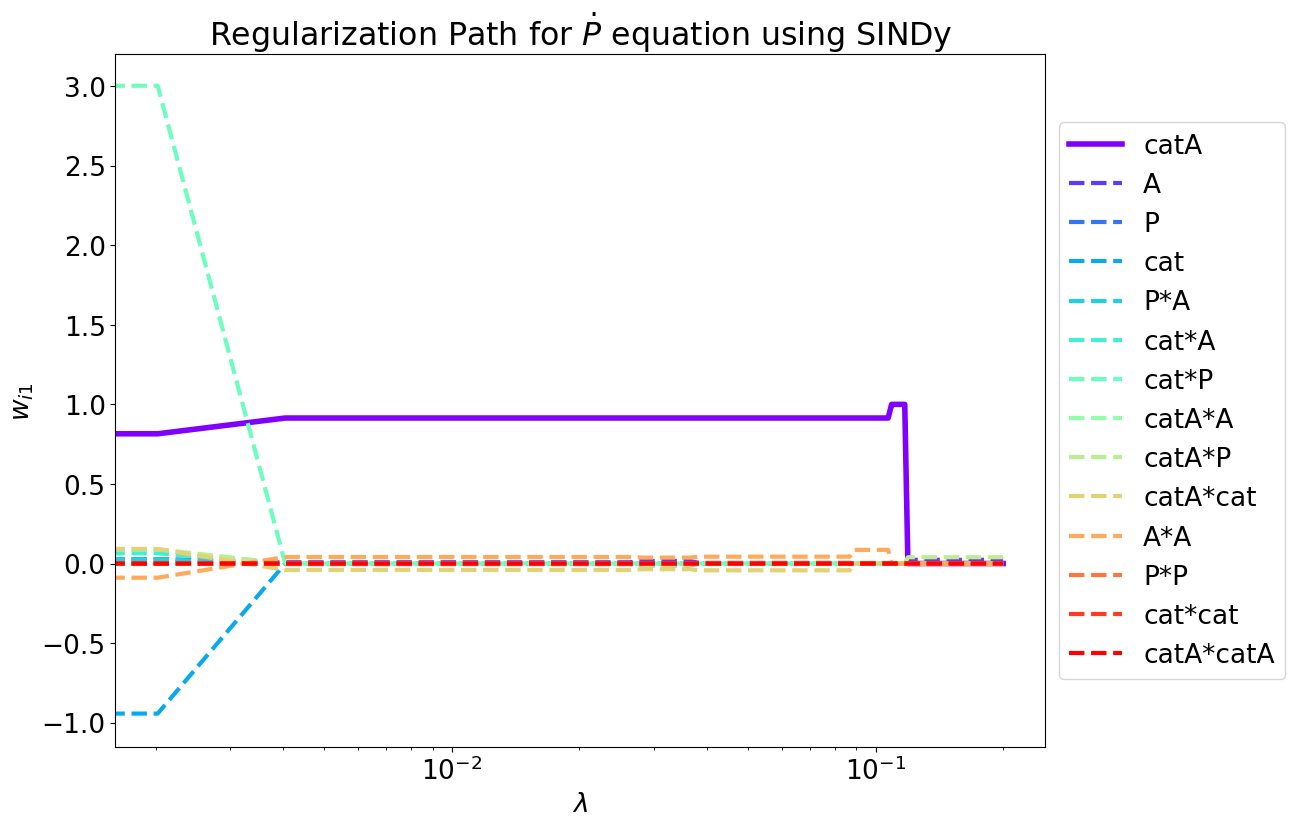

In [58]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 1, labels)
plt.title("Regularization Path for $\dot{P}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

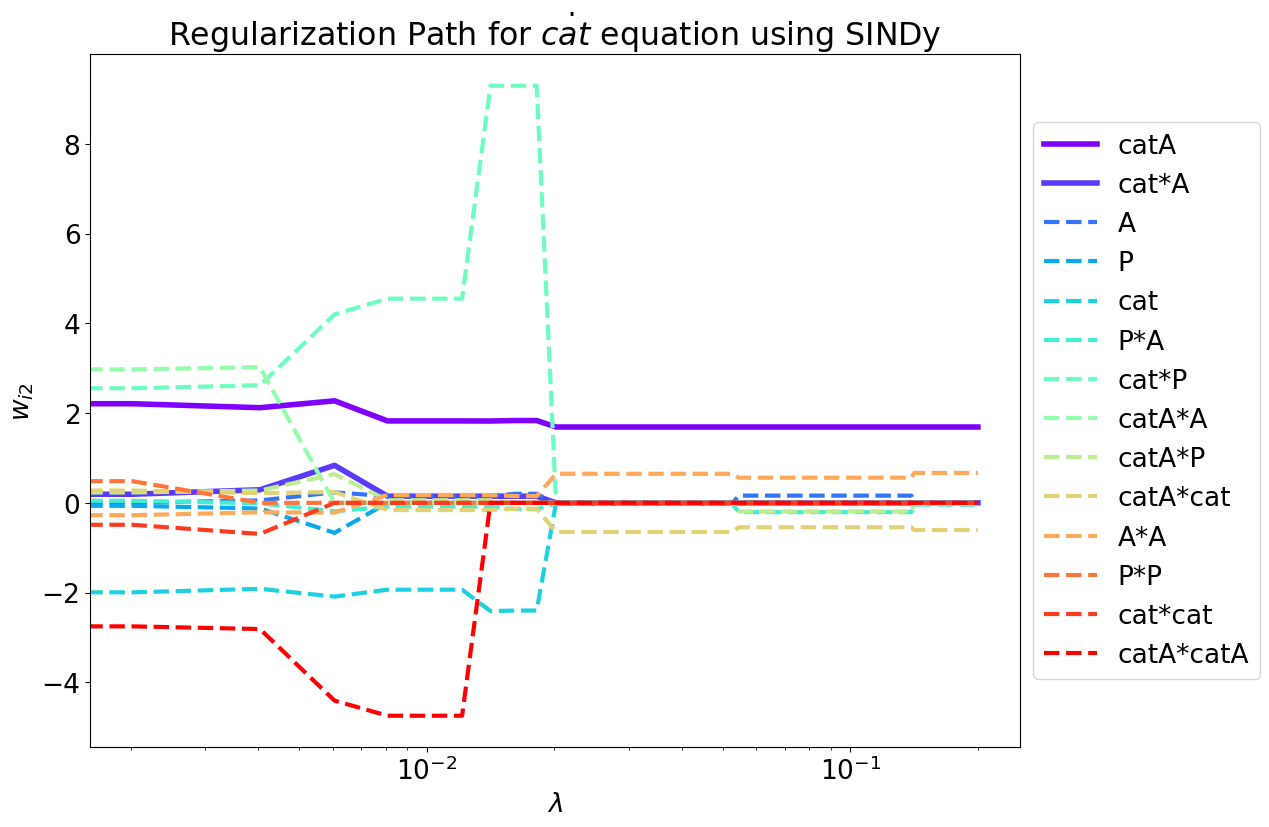

In [59]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 2, labels)
plt.title("Regularization Path for $\dot{cat}$ equation using SINDy")
plt.xlabel('$\lambda$')

(array([3, 5]),)
(array([ 0,  1,  2,  4,  6,  7,  8,  9, 10, 11, 12, 13]),)


Text(0.5, 0, '$\\lambda$')

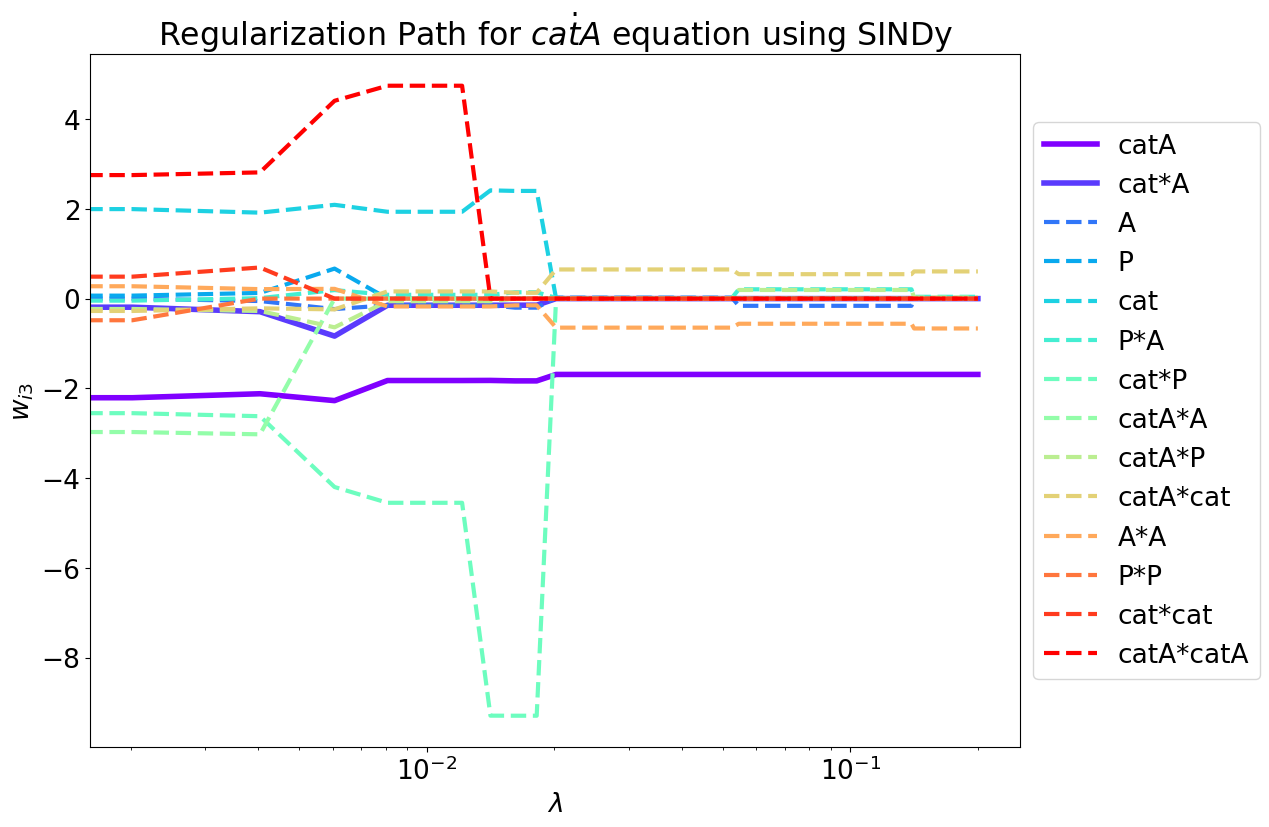

In [60]:
solvers.plot_regularization_path(alphas, np.array(W_sindy_arr), W0, 3, labels)
plt.title("Regularization Path for $\dot{catA}$ equation using SINDy")
plt.xlabel('$\lambda$')

In [61]:
opt = ps.STLSQ(threshold = 0.05, alpha=0.05) 
custom_library, feature_names = make_library('A1r')
model_custom = ps.SINDy(feature_library=custom_library,  feature_names=feature_names, optimizer = opt)
model_custom.fit(X, t = T)
model_custom.print()
W_sindy = model_custom.coefficients()

(A)' = -0.045 A*A + -0.556 A*cat + 1.397 A*catA
(P)' = 0.000
(cat)' = 0.000
(catA)' = 0.000


/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)
/Users/apple/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pysindy/optimizers/stlsq.py:195: UserWarning: Sparsity parameter is too big (0.05) and eliminated all coefficients
  "coefficients".format(self.threshold)


In [62]:
mechanisms.print_equation(labels, W_sindy, 1e-5)

-0.04[P*A]-0.56[catA*cat]+1.40[A*A]
______

______

______

______
sparsity: 3


3

In [63]:
_, er_w = mechanisms.get_residual(W_sindy, W0)

absolute residual 3.9066506280276796
relative residual 2.597562687239602
